# XGBoost, CatBoost, LightGBM ensemble - CV 0.676 - Public LB 0.683 - Private LB 0.683

Built an ensemble of XGBoost, CatBoost,and LightGBM to achieve a maximum CV score of 0.676 and LB score of 0.683.

The baseline notebook from Chris Deotte's can be found [here](https://www.kaggle.com/code/cdeotte/xgboost-catboost-baseline-cv-668-lb-668).

# Pip Install Libraries for Metric
Since internet must be turned off for submission, we pip install from Chris Deotte's notebook [here][1] where he downloaded the WHL files.

[1]: https://www.kaggle.com/code/cdeotte/pip-install-lifelines

In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5ea9cb62196ce4bb0f978ba58a33bf089d935d8900083bd05034311299cce350
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


# Imports

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost
from xgboost import XGBRegressor, XGBClassifier
import xgboost

from sklearn.model_selection import RandomizedSearchCV, KFold
from metric import score

from lifelines import NelsonAalenFitter

# Ignore verbose warnings
warnings.filterwarnings("ignore")

# Load Train and Test data

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


# EDA on Train Targets
There are two train targets `efs` and `efs_time`. When `efs==1` we know patient **did not survive** and we know time of death is `efs_time`. When `efs==0` we **do not know** if patient survived or not, but we do know that patient survived at least as long as `efs_time`.

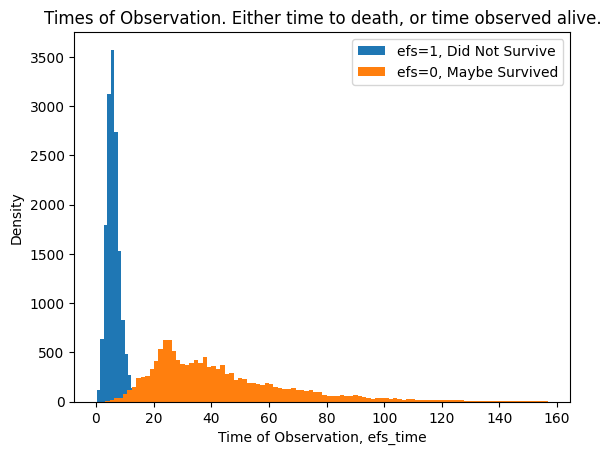

In [4]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to death, or time observed alive.")
plt.legend()
plt.show()

# Transform Two Train Targets into One Target using Nelson-Aalen
Both targets, `efs` and `efs_time`, provide useful information. We combine them into a single target using the `Nelson-Aalen` estimator, converting it into a score that tends to work better with ML algorithms rather than raw probabilities. While the plot below shows the Nelson-Aalen survival function (based on probabilities), note that our model ultimately uses the derived **risk score**.

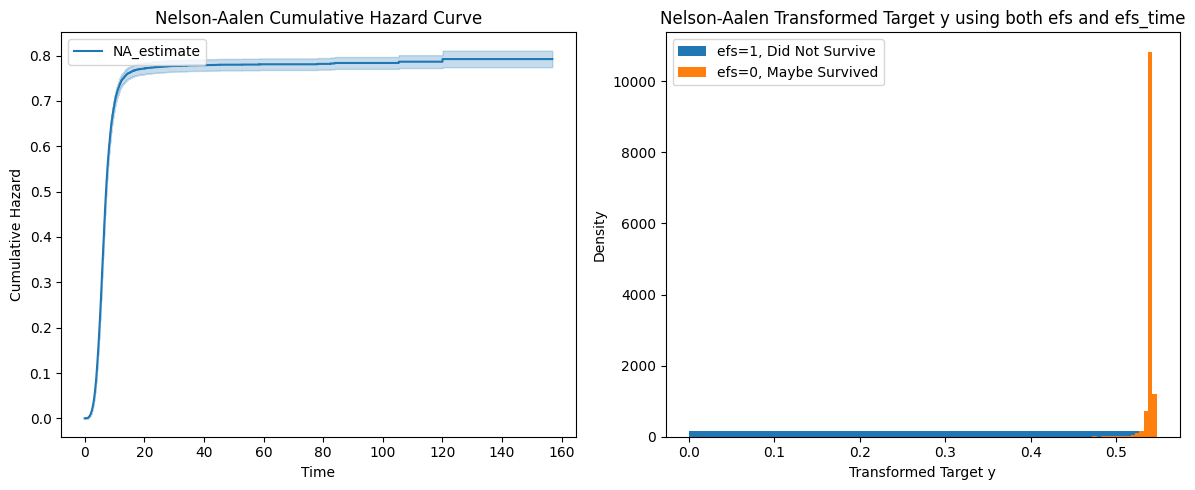

In [5]:
# Fit Nelson-Aalen Estimator
naf = NelsonAalenFitter()
naf.fit(train['efs_time'], event_observed=train['efs'])

# Compute Transformed Target y (1 - estimated survival)
y = 1 - np.exp(-naf.cumulative_hazard_at_times(train['efs_time']).values)
train["y"] = y

# Create subplots: 1st for Nelson-Aalen function, 2nd for transformed target y
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Nelson-Aalen Cumulative Hazard Curve
naf.plot_cumulative_hazard(ax=axes[0])
axes[0].set_title("Nelson-Aalen Cumulative Hazard Curve")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Cumulative Hazard")

# Plot transformed target distribution
plt.hist(train.loc[train.efs == 1, "y"], bins=100, label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs == 0, "y"], bins=100, label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Nelson-Aalen Transformed Target y using both efs and efs_time")
plt.legend()

plt.tight_layout()
plt.show()

# Data exploration

## Features
There are a total of 57 features. From these 35 are categorical and 22 are numerical.

In [6]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [7]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [8]:
NUMS = []
for c in FEATURES:
    if train[c].dtype != "object":
        NUMS.append(c)

print(f"In these features, there are {len(NUMS)} NUMERICAL FEATURES: {NUMS}\n")

In these features, there are 22 NUMERICAL FEATURES: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10']



We examine the distributions of numerical features and quickly notice that all, except `donor_age` and `age_at_hct`, have very few unique values. This suggests that these features can be converted to categorical variables for the CatBoost model, which handles them more effectively than treating them as numerical features.

Team Contribution

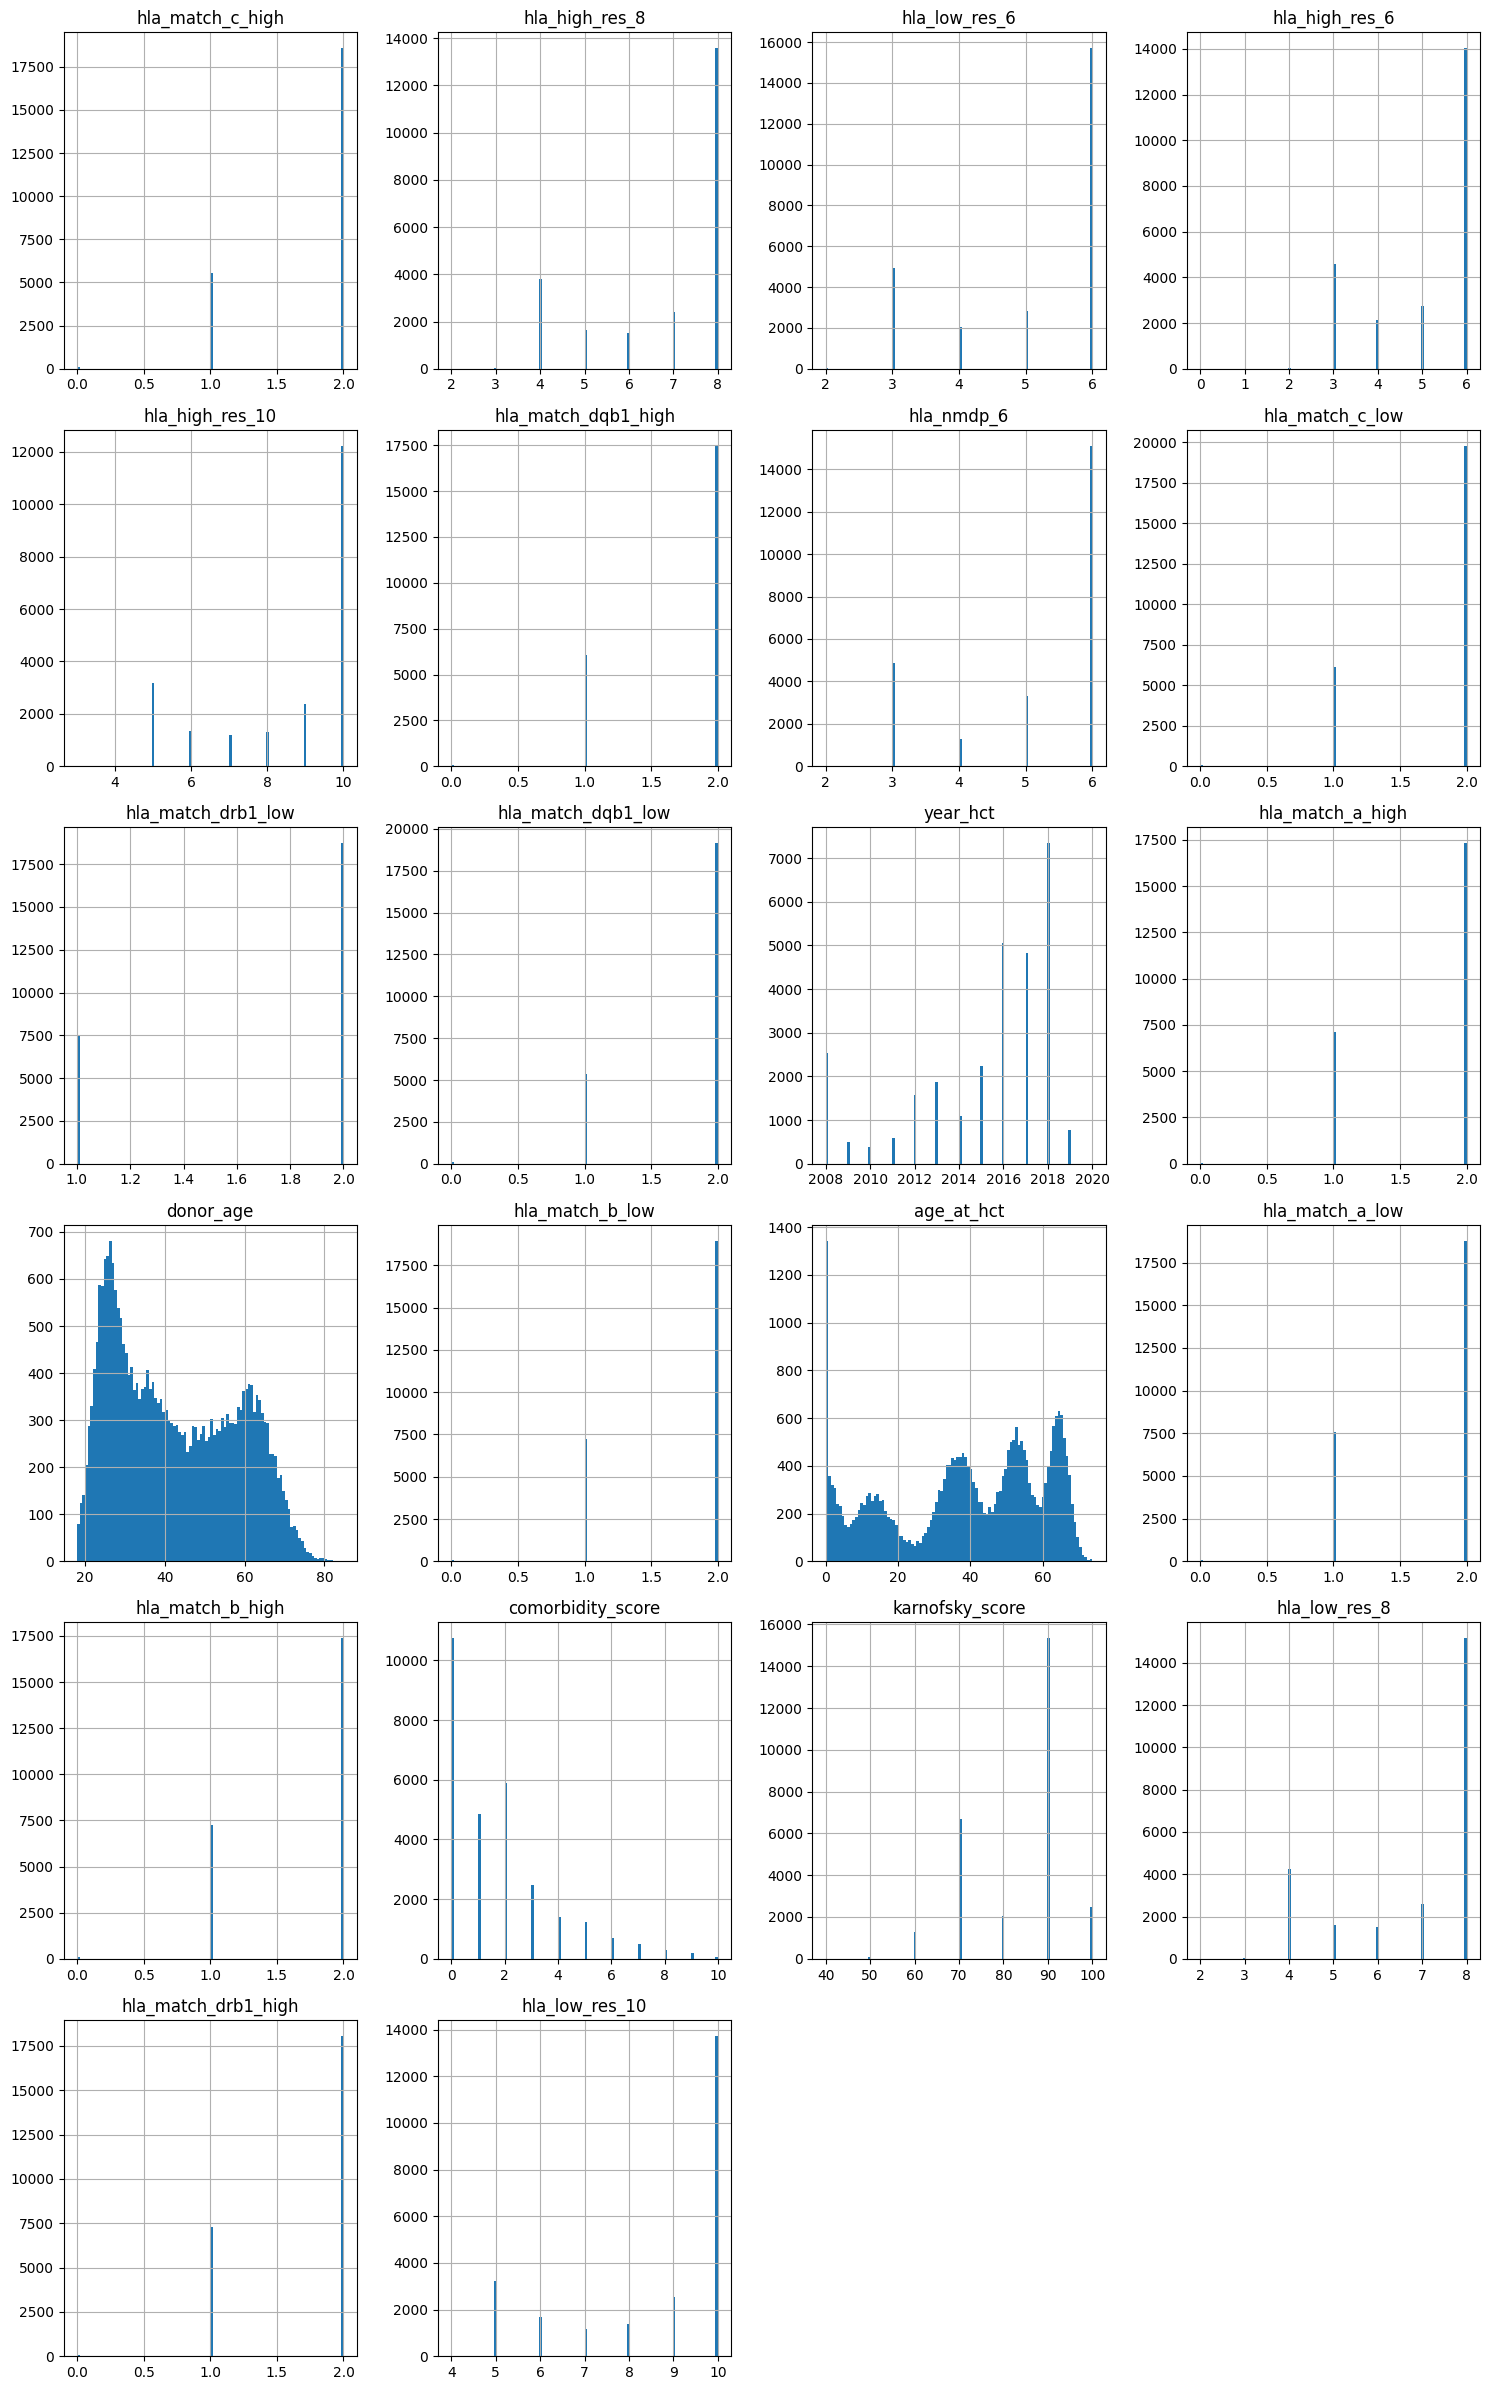

In [9]:
n_cols = 4 
n_rows = (len(NUMS) + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    train[col].hist(bins=100, ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
print("Unique values per feature")
for f in NUMS:
    print(f"{f}, {train[f].dtype}: {np.unique(train[f])}")

Unique values per feature
hla_match_c_high, float64: [ 0.  1.  2. nan]
hla_high_res_8, float64: [ 2.  3.  4.  5.  6.  7.  8. nan]
hla_low_res_6, float64: [ 2.  3.  4.  5.  6. nan]
hla_high_res_6, float64: [ 0.  2.  3.  4.  5.  6. nan]
hla_high_res_10, float64: [ 3.  4.  5.  6.  7.  8.  9. 10. nan]
hla_match_dqb1_high, float64: [ 0.  1.  2. nan]
hla_nmdp_6, float64: [ 2.  3.  4.  5.  6. nan]
hla_match_c_low, float64: [ 0.  1.  2. nan]
hla_match_drb1_low, float64: [ 1.  2. nan]
hla_match_dqb1_low, float64: [ 0.  1.  2. nan]
year_hct, int64: [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
hla_match_a_high, float64: [ 0.  1.  2. nan]
donor_age, float64: [18.01  18.012 18.016 ... 82.509 84.8      nan]
hla_match_b_low, float64: [ 0.  1.  2. nan]
age_at_hct, float64: [4.4000e-02 4.6000e-02 5.0000e-02 ... 7.3670e+01 7.3717e+01 7.3726e+01]
hla_match_a_low, float64: [ 0.  1.  2. nan]
hla_match_b_high, float64: [ 0.  1.  2. nan]
comorbidity_score, float64: [ 0.  1.  2.  3.  4. 

We also plot the **correlation matrix** to analyze how the variables relate to each other. We observe that many features are highly correlated (score 0.9 or higher), meaning they provide very similar information — so we can remove some of them. Although GBDT models can still benefit from highly correlated features, we achieved a small improvement in both CV and LB scores by removing some redundant ones.

Team Contribution

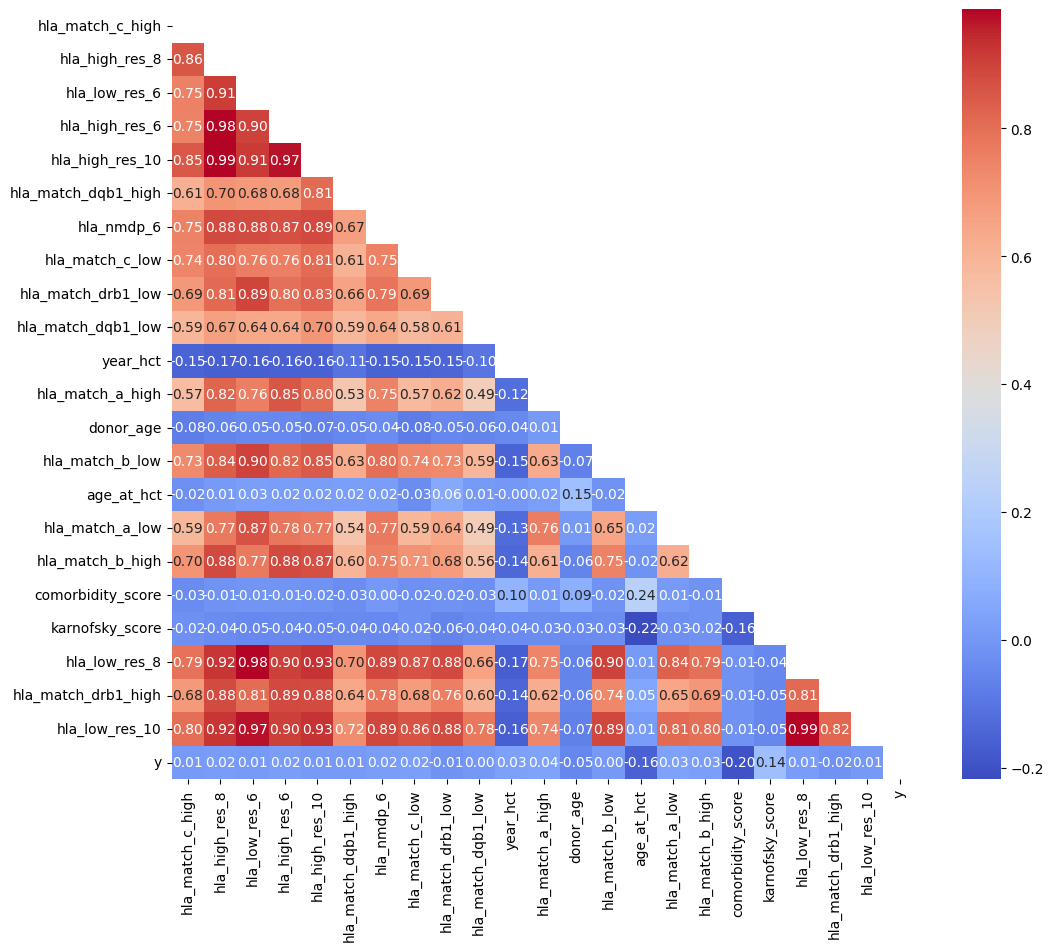

In [11]:
plt.figure(figsize=(12, 10))
temp = train[NUMS].copy()
temp['y'] = train['y']
corr_matrix = temp.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.show()

### Removing redundant features

In [12]:
def reduce_hla_features(df):
    """
    Reduces HLA-related features based on correlation and importance.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with reduced HLA features.
    """
    df = df.copy()

    # Columns to drop
    cols_to_drop = [
        'hla_high_res_8',
        'hla_high_res_6',
        'hla_low_res_6',
        'hla_low_res_8'
    ]

    # Drop columns
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(cols_to_drop, axis=1)

    return df
   

train = reduce_hla_features(train)
test = reduce_hla_features(test)

print("Train shape after HLA reduction:", train.shape)
print("Test shape after HLA reduction:", test.shape)

Train shape after HLA reduction: (28800, 57)
Test shape after HLA reduction: (3, 54)


## Feature engineering

In [13]:
def transform_conditioning_intensity(df):
    """
    Groups the 'conditioning_intensity' feature based on domain knowledge of intensity.
    """
    df = df.copy()
    
    # Group categories
    def group_intensity(intensity):
        if intensity in ['RIC', 'NMA']:
            return 'Reduced Intensity'
        elif intensity == 'MAC':
            return 'MAC'
        else:
            return 'Unknown'

    df['conditioning_intensity_grouped'] = df['conditioning_intensity'].apply(group_intensity)

    return df

train = transform_conditioning_intensity(train)
test = transform_conditioning_intensity(test)

In [14]:
# Create age difference feature (donor_age - age_at_hct)
train['age_difference'] = train['donor_age'] - train['age_at_hct']
test['age_difference'] = test['donor_age'] - test['age_at_hct']

In [15]:
# Makes sex_match as a binary feature
def add_sex_match_binary_feature(df):
    df['sex_match_binary'] = df['sex_match'].map({'M-M': 1, 'F-F': 1, 'F-M': 0, 'M-F': 0})
    
    return df

train = add_sex_match_binary_feature(train)
test = add_sex_match_binary_feature(test)

In [16]:
# Create num_diseases and multiple_diseases features to flag patients with multiple diseases
def add_num_diseases_and_multiple_diseases_features(df):
   
    # Columns with disease-related features
    disease_columns = [
            'diabetes',
            'psych_disturb',
            'arrhythmia',
            'renal_issue',
            'pulm_severe',
            'hepatic_severe',
            'obesity',
            'prior_tumor',
            'rheum_issue',
            'cardiac',
            'pulm_moderate',
            'hepatic_mild'
        ]
    
    df_copy = df[disease_columns].copy()
    
    df_copy = df_copy.applymap({'Yes': 1, 'No': 0, 'Not done': None}.get)

    df_copy = df_copy.apply(pd.to_numeric, errors='coerce')
    
    # Sum across the rows to count how many diseases are marked as 'Yes' (1)
    df['num_diseases'] = df_copy.sum(axis=1)
    
    # Create the 'multiple_diseases' feature, flagging patients with more than one disease (i.e., num_diseases > 1)
    df['multiple_diseases'] = (df['num_diseases'] > 1).astype('category')

    return df

train = add_num_diseases_and_multiple_diseases_features(train)
test = add_num_diseases_and_multiple_diseases_features(test)


In [17]:
def impute_not_done(df):
    """
    Imputes missing values in disease-related categorical columns with 'Not done'.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed as 'Not done'
                      in the specified columns.
    """
    cols_to_impute = [
        'diabetes',
        'psych_disturb',
        'arrhythmia',
        'renal_issue',
        'pulm_severe',
        'hepatic_severe',
        'obesity',
        'prior_tumor',
        'rheum_issue',
        'cardiac',
        'pulm_moderate',
        'hepatic_mild'
    ]

    for col in cols_to_impute:
        if col in df.columns:  # Check if the column exists in the DataFrame
            df[col] = df[col].fillna('Not done')
    return df

train = impute_not_done(train)
test = impute_not_done(test)

# Verify the imputation
print(train[['diabetes','psych_disturb','arrhythmia', 'renal_issue', 'pulm_severe', 'hepatic_severe', 'obesity',
        'prior_tumor', 'rheum_issue', 'cardiac', 'pulm_moderate', 'hepatic_mild']].isnull().sum())

print(test[['diabetes','psych_disturb','arrhythmia', 'renal_issue', 'pulm_severe', 'hepatic_severe', 'obesity',
        'prior_tumor', 'rheum_issue', 'cardiac', 'pulm_moderate', 'hepatic_mild']].isnull().sum())


diabetes          0
psych_disturb     0
arrhythmia        0
renal_issue       0
pulm_severe       0
hepatic_severe    0
obesity           0
prior_tumor       0
rheum_issue       0
cardiac           0
pulm_moderate     0
hepatic_mild      0
dtype: int64
diabetes          0
psych_disturb     0
arrhythmia        0
renal_issue       0
pulm_severe       0
hepatic_severe    0
obesity           0
prior_tumor       0
rheum_issue       0
cardiac           0
pulm_moderate     0
hepatic_mild      0
dtype: int64


Update the FEATURES, NUMS and CATS arrays.

Team Contribution

In [18]:
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'conditioning_intensity_grouped', 'age_difference', 'sex_match_binary', 'num_diseases', 'multiple_diseases']


In [19]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 36 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'conditioning_intensity_grouped']


In [20]:
NUMS = []
for c in FEATURES:
    if train[c].dtype != "object":
        NUMS.append(c)

print(f"In these features, there are {len(NUMS)} NUMERICAL FEATURES: {NUMS}\n")

In these features, there are 22 NUMERICAL FEATURES: ['hla_match_c_high', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_match_drb1_high', 'hla_low_res_10', 'age_difference', 'sex_match_binary', 'num_diseases', 'multiple_diseases']



### Label encoding

We will label encode the categorical features. Then our XGB and CAT model will accept these as categorical features and process them special internally. We leave the numerical feature NANs as NANs because GBDT (like XGB and CAT) can handle NAN and will use this information.

In [21]:
combined = pd.concat([train,test],axis=0,ignore_index=True)

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train_xgboost = combined.iloc[:len(train)].copy()
test_xgboost = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, conditioning_intensity_grouped, 

# XGBoost
We train XGBoost model with CV 0.674

In [22]:
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 2.0.3


## RandomizedSearchCV

We perform RandomizedSearchCV to find the optimal set of Hyperparameters. This process takes up to 1 hour and it is currently commented out. In the last run, this set was found the be the best: `{'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 5000, 'min_child_weight': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5}`. We train our XGBoost model with these parameters.

Team Contribution

In [23]:
# xgb_model = XGBRegressor(
#     device = 'cuda',
#     enable_categorical=True
# )

# param_dist = {
#     "max_depth": [3, 4, 5, 6],
#     "learning_rate": [0.01, 0.02, 0.05],
#     "n_estimators": [3000, 5000, 7000],
#     "colsample_bytree": [0.5, 0.7, 0.9],
#     "subsample": [0.7, 0.8, 0.9],
#     "min_child_weight": [5, 10, 20, 30],
#     "reg_lambda": [1, 5, 10, 20],
#     "reg_alpha": [0, 1, 2, 5, 15],
# }

# random_search = RandomizedSearchCV(
#     xgb_model, param_distributions=param_dist,
#     n_iter=20, scoring="neg_mean_absolute_error",
#     cv=5, verbose=1, n_jobs=-1
# )

# # Fit the model
# random_search.fit(train_xgboost[FEATURES], train_xgboost["y"])
# # Get best parameters
# print(random_search.best_params_)

In [24]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train_xgboost))
pred_xgb = np.zeros(len(test_xgboost))

for i, (train_index, test_index) in enumerate(kf.split(train_xgboost)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train_xgboost.loc[train_index,FEATURES].copy()
    y_train = train_xgboost.loc[train_index,"y"]
    x_valid = train_xgboost.loc[test_index,FEATURES].copy()
    y_valid = train_xgboost.loc[test_index,"y"]
    x_test = test_xgboost[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=5,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=5000,  
        learning_rate=0.01,
        min_child_weight=20,
        reg_lambda=10,
        reg_alpha=1,
        enable_categorical=True,
        objective='reg:squarederror',
        eval_metric="mae",
        early_stopping_rounds=75
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid, iteration_range=(0, model_xgb.best_iteration))
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test, iteration_range=(0, model_xgb.best_iteration))

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-mae:0.15732
[500]	validation_0-mae:0.13537
[1000]	validation_0-mae:0.13134
[1500]	validation_0-mae:0.12962
[2000]	validation_0-mae:0.12871
[2500]	validation_0-mae:0.12811
[3000]	validation_0-mae:0.12784
[3500]	validation_0-mae:0.12761
[4000]	validation_0-mae:0.12743
[4180]	validation_0-mae:0.12740
#########################
### Fold 2
#########################
[0]	validation_0-mae:0.15255
[500]	validation_0-mae:0.13106
[1000]	validation_0-mae:0.12786
[1500]	validation_0-mae:0.12629
[2000]	validation_0-mae:0.12542
[2500]	validation_0-mae:0.12486
[3000]	validation_0-mae:0.12450
[3258]	validation_0-mae:0.12434
#########################
### Fold 3
#########################
[0]	validation_0-mae:0.15516
[500]	validation_0-mae:0.13305
[1000]	validation_0-mae:0.12935
[1500]	validation_0-mae:0.12766
[2000]	validation_0-mae:0.12669
[2500]	validation_0-mae:0.12602
[3000]	validation_0-mae:0.12555
[3500]	validation_0-mae

In [25]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()

y_pred_train = train[["ID", "y"]].copy()
y_pred_test = test[["ID"]].copy()

y_pred_xgb = train[["ID"]].copy()
y_pred_xgb["prediction"] = -oof_xgb
m = score(y_true.copy(), y_pred_xgb.copy(), "ID")
print(f"\nOverall CV for XGBoost =",m)

y_pred_train["prediction_xgb"] = -oof_xgb
y_pred_test["prediction_xgb"] = -pred_xgb


Overall CV for XGBoost = 0.6738689932412456


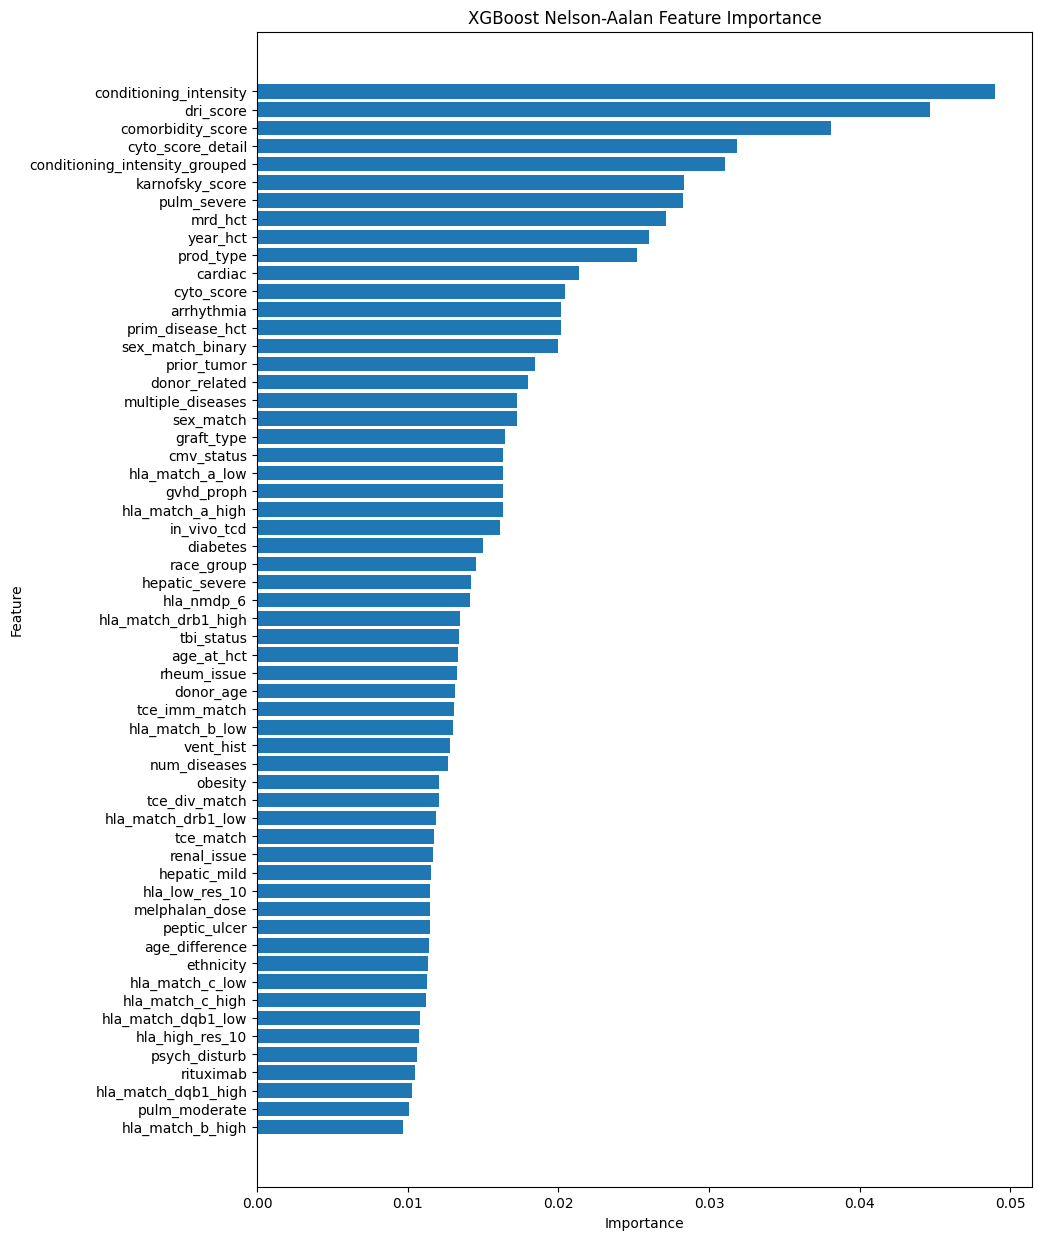

In [26]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Nelson-Aalan Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# CatBoost
We train CatBoost model with CV 0.674

In [27]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
categorical_features = CATS.copy()

for f in NUMS:
    if (f != 'age_at_hct') and (f != 'donor_age') and (f != 'age_difference'):
        combined[f] = combined[f].fillna("nan").astype(str).astype("category")
        categorical_features.append(f)
    print(f"{f}: {combined[f].dtype}")

train_catboost = combined.iloc[:len(train)].copy()
test_catboost = combined.iloc[len(train):].reset_index(drop=True).copy()

hla_match_c_high: category
hla_high_res_10: category
hla_match_dqb1_high: category
hla_nmdp_6: category
hla_match_c_low: category
hla_match_drb1_low: category
hla_match_dqb1_low: category
year_hct: category
hla_match_a_high: category
donor_age: float64
hla_match_b_low: category
age_at_hct: float64
hla_match_a_low: category
hla_match_b_high: category
comorbidity_score: category
karnofsky_score: category
hla_match_drb1_high: category
hla_low_res_10: category
age_difference: float64
sex_match_binary: category
num_diseases: category
multiple_diseases: category


In [28]:
print("Using CatBoost version",catboost.__version__)

Using CatBoost version 1.2.7


We perform RandomizedSearchCV to find the optimal set of Hyperparameters. This process takes up to 3-4 hours and it is currently commented out. In the last run, this subset was found the be the best: `{'depth': 5, 'learning_rate': 0.05, 'iterations': 5000, 'l2_leaf_reg': 5, 'border_count': 256, 'random_strength': 1}`. We train our CatBoost model with these parameters.               

In [29]:
# # Initialize CatBoost model
# cat_model = CatBoostRegressor(
#     task_type="GPU",
#     verbose=500
# )

# # Define parameter grid for random search
# param_dist = {
#     "depth": [4, 5, 6, 8],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "iterations": [3000, 5000, 7000],
#     "l2_leaf_reg": [1, 5, 10, 20],
#     "border_count": [32, 64, 128, 256],
#     "random_strength": [1, 3, 5],
# }

# # Perform Randomized Search
# random_search = RandomizedSearchCV(
#     cat_model, param_distributions=param_dist,
#     n_iter=20, scoring="neg_mean_absolute_error",
#     cv=5, verbose=False, n_jobs=-1
# )

# # Fit the model
# random_search.fit(train_catboost[FEATURES], train_catboost["y"], cat_features=categorical_features)

# # Print best parameters
# print(random_search.best_params_)

In [30]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train_catboost))
pred_cat = np.zeros(len(test_catboost))

for i, (train_index, test_index) in enumerate(kf.split(train_catboost)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train_catboost.loc[train_index,FEATURES].copy()
    y_train = train_catboost.loc[train_index,"y"]
    x_valid = train_catboost.loc[test_index,FEATURES].copy()
    y_valid = train_catboost.loc[test_index,"y"]
    x_test = test_catboost[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",                  
        learning_rate=0.05,               
        iterations=5000,                  
        depth=5,                          
        l2_leaf_reg=5,                    
        random_strength=1,              
        border_count=256,                 
        grow_policy='Lossguide',          
        early_stopping_rounds=75
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=categorical_features,
              verbose=500)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid, ntree_end=model_cat.get_best_iteration())
    # INFER TEST
    pred_cat += model_cat.predict(x_test, ntree_end=model_cat.get_best_iteration())

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1755370	test: 0.1771488	best: 0.1771488 (0)	total: 121ms	remaining: 10m 3s
500:	learn: 0.1470913	test: 0.1585270	best: 0.1585270 (500)	total: 9.76s	remaining: 1m 27s
1000:	learn: 0.1400364	test: 0.1575786	best: 0.1575786 (1000)	total: 18.8s	remaining: 1m 15s
bestTest = 0.1574300498
bestIteration = 1151
Shrink model to first 1152 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1760172	test: 0.1728490	best: 0.1728490 (0)	total: 24.6ms	remaining: 2m 2s
500:	learn: 0.1477745	test: 0.1537895	best: 0.1537658 (493)	total: 9.29s	remaining: 1m 23s
1000:	learn: 0.1409572	test: 0.1532101	best: 0.1531846 (954)	total: 18.2s	remaining: 1m 12s
bestTest = 0.1529575773
bestIteration = 1117
Shrink model to first 1118 iterations.
#########################
### Fold 3
#########################
0:	learn: 0.1755894	test: 0.1765827	best: 0.1765827 (0)	total: 19.2ms	remaining: 1m 35s
500:	learn: 0.

In [31]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()

y_pred_cat = train[["ID"]].copy()
y_pred_cat["prediction"] = -oof_cat
m = score(y_true.copy(), y_pred_cat.copy(), "ID")
print(f"\nOverall CV for CatBoost =",m)

y_pred_train["prediction_cat"] = -oof_cat
y_pred_test["prediction_cat"] = -pred_cat


Overall CV for CatBoost = 0.6738123353611978


## CatBoost Feature Importance

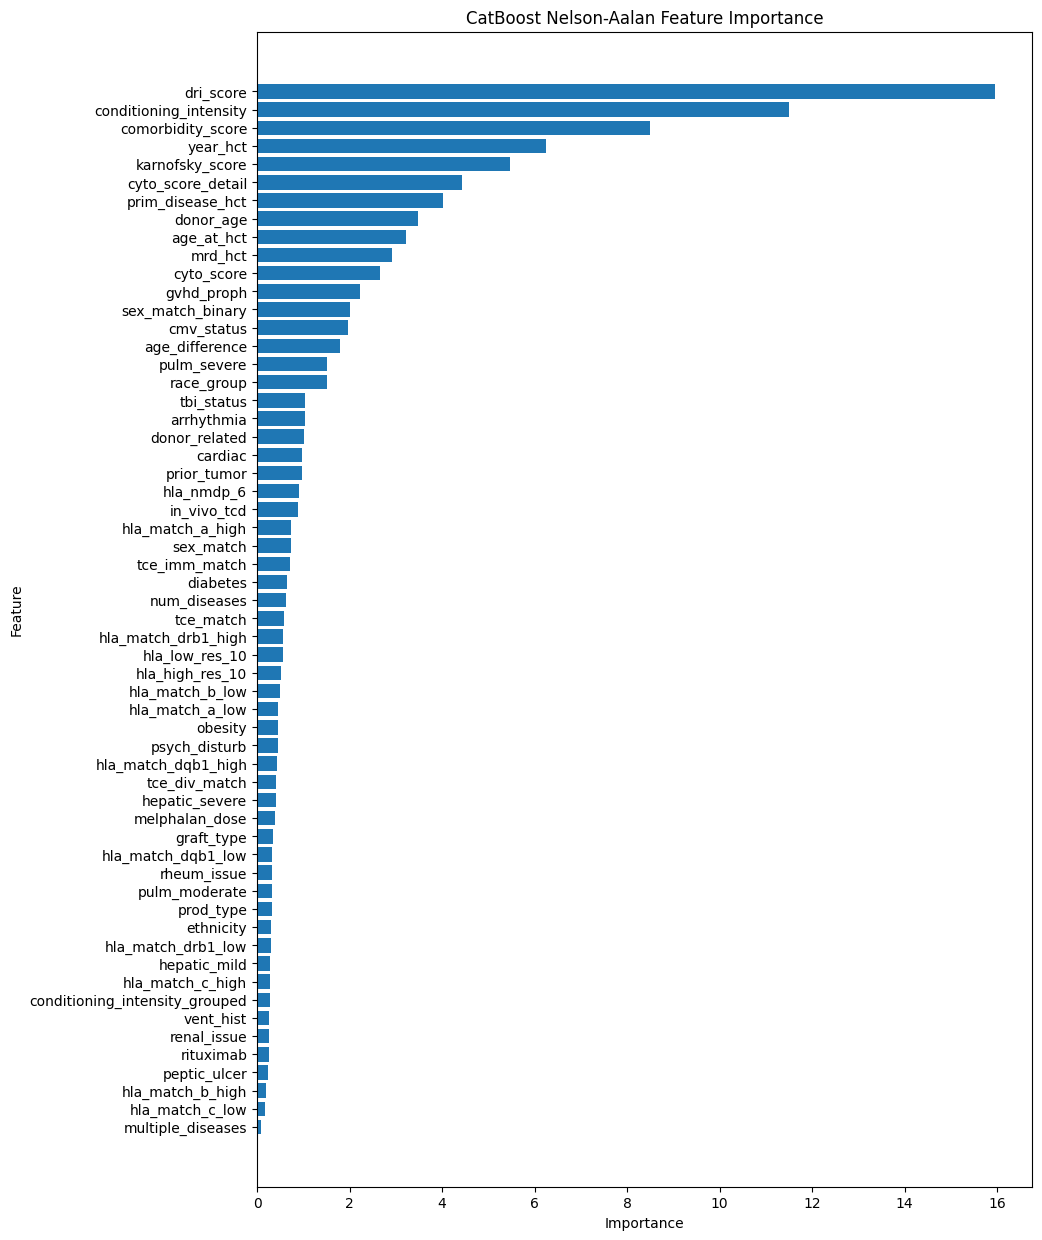

In [32]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Nelson-Aalan Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# LightGBM

We train LightGBM model with CV 0.673

In [33]:
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.2.0


In [34]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
categorical_features = CATS.copy()

for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        combined[c] = combined[c].astype("category")
        
train_lgb = combined.iloc[:len(train)].copy()
test_lgb = combined.iloc[len(train):].reset_index(drop=True).copy()

We perform RandomizedSearchCV to find the optimal set of Hyperparameters. This process takes up to 1 hour and it is currently commented out. In the last run, this subset was found the be the best: `{'subsample': 1.0, 'num_leaves': 32, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.01}`. We train our LightGBM model with these parameters.

In [35]:
# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [32, 64, 128],
#     'max_depth': [3, 5, 10],
#     'n_estimators': [2000, 3500, 5000],
#     'subsample': [0.8, 1.0]
# }

# model = lgb.LGBMRegressor(objective='regression', device="gpu", verbose=-1)

# random_search = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_dist, 
#     n_iter=20,  # Number of random samples to try
#     cv=5,  # 5-fold cross-validation
#     verbose=100, 
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(train_lgb[FEATURES], train_lgb["y"])

# # Best parameters found
# best_params = random_search.best_params_
# print("Best Parameters:", best_params)

In [36]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
oof_lgb = np.zeros(len(train_lgb))
pred_lgb = np.zeros(len(test_lgb))

# Loop through the folds
for i, (train_index, test_index) in enumerate(kf.split(train_lgb)):

    
    # Split data into training and validation sets
    x_train = train_lgb.loc[train_index, FEATURES].copy()
    y_train = train_lgb.loc[train_index, "y"]    
    x_valid = train_lgb.loc[test_index, FEATURES].copy()
    y_valid = train_lgb.loc[test_index, "y"]
    x_test = test_lgb[FEATURES].copy()

    # Initialize the LGBM model
    model_lgb = LGBMRegressor(
        device="gpu", 
        max_depth=5, 
        colsample_bytree=0.4,
        num_leaves=32,
        n_estimators=2000, 
        learning_rate=0.01,
        subsample=1.0,
        objective="regression", 
        verbose=-1,
        early_stopping_rounds=75,
    )

    # Fit the model with detailed logging using verbose_eval
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        # verbose_eval=500  # Log every 500 iterations
    )

    # Get the best iteration
    best_iteration = model_lgb.best_iteration_
    print(f"Best Iteration for Fold {i+1}: {best_iteration}")

    # INFER OOF (Out of Fold predictions) using best iteration
    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration=best_iteration)
    
    # INFER TEST (for the final test predictions) using best iteration
    pred_lgb += model_lgb.predict(x_test, num_iteration=best_iteration)

# Compute average test predictions across all folds
pred_lgb /= FOLDS

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Best Iteration for Fold 1: 1999
Best Iteration for Fold 2: 1996
Best Iteration for Fold 3: 1996
Best Iteration for Fold 4: 2000
Best Iteration for Fold 5: 1985
Best Iteration for Fold 6: 1999
Best Iteration for Fold 7: 1994
Best Iteration for Fold 8: 1996
Best Iteration for Fold 9: 2000
Best Iteration for Fold 10: 1996


In [37]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()

y_pred_lgb = train[["ID"]].copy()
y_pred_lgb["prediction"] = -oof_lgb
m = score(y_true.copy(), y_pred_lgb.copy(), "ID")
print(f"\nOverall CV for LightGBM =",m)

y_pred_train["prediction_lgb"] = -oof_lgb
y_pred_test["prediction_lgb"] = -pred_lgb


Overall CV for LightGBM = 0.6732431190782704


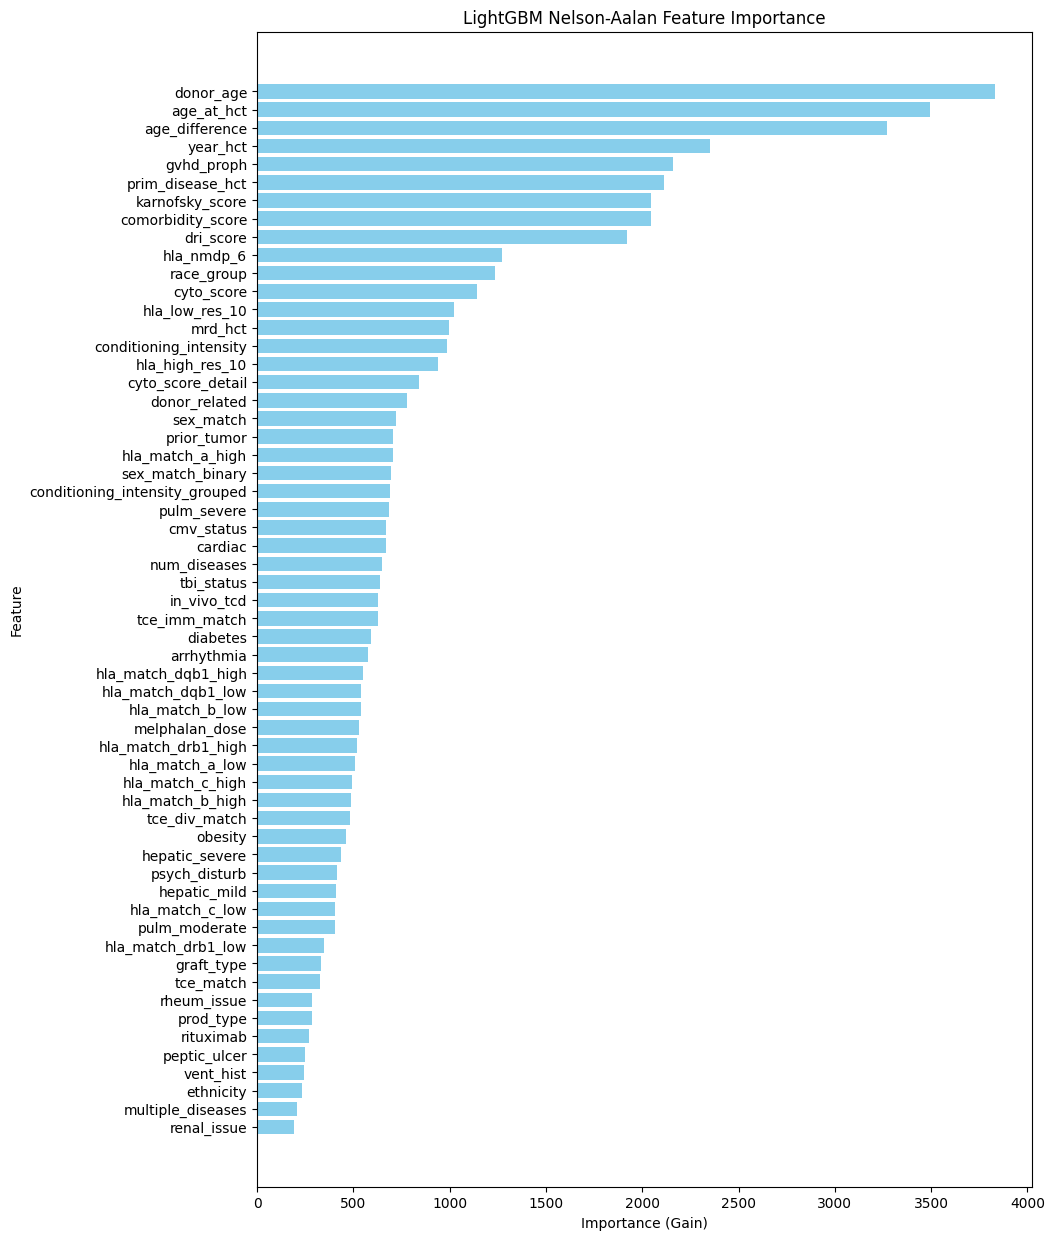

In [38]:
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM Nelson-Aalan Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# Ensemble XGBoost, CatBoost and LightGBM
We ensemble our XGBoost and CatBoost to achieve CV 0.676!

In [39]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_xgb -oof_cat -oof_lgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6761413303699194


# Create Submission CSV

In [40]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = -pred_xgb -pred_cat -pred_lgb
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,-1.544729
1,28801,-1.050781
2,28802,-1.674357
